-   [Finding Candidate Binding Sites for Known Transcription Factors via
    Sequence
    Matching](#finding-candidate-binding-sites-for-known-transcription-factors-via-sequence-matching)

Finding Candidate Binding Sites for Known Transcription Factors via Sequence Matching
=====================================================================================

The binding of transcription factor proteins (TFs) to DNA promoter regions upstream of gene transcription start sites (TSSs) is one of the most important mechanisms by which gene expression, and thus many cellular processes, are controlled. Though in recent years many new kinds of data have become available for identifying transcription factor binding sites (TFBSs) -- ChIP-seq and DNase I hypersensitivity regions among them -- sequence matching continues to play an important role.

In this workflow we demonstrate Bioconductor techniques for finding candidate TF binding sites in DNA sequence using the model organism Saccharomyces cerevisiae. The methods demonstrated here apply equally well to other organisms.

-   [Introduction](#introduction)
-   [Installation](#install-and-use)
-   [Biological Background](#biological-background)
-   [Introduction to Motif-based Sequence Search](#sequence-search)
-   [Minimal Example](#compact-summary)
-   [Sample Workflow](#sample-workflow) (an extended example)
-   [Biological Summary](#biological-summary)
-   [Exploring Package Content](#exploring-package-content)

<h2 id="introduction">
Introduction
</h2>
Eukaryotic gene regulation can be very complex. Transcription factor binding to promoter DNA sequences is a stochastic process, and imperfect matches can be sufficient for binding. Chromatin remodeling, methylation, histone modification, chromosome interaction, distal enhancers, and the cooperative binding of transcription co-factors all play an important role. We avoid most of this complexity in this demonstration workflow in order to examine transcription factor binding sites in a small set of seven broadly co-expressed Saccharomyces cerevisiae genes of related function. These genes exhibit highly correlated mRNA expression across 200 experimental conditions, and are annotated to Nitrogen Catabolite Repression (NCR), the means by which yeast cells switch between using rich and poor nitrogen sources.

We will see, however, that even this small collection of co-regulated genes of similar function exhibits considerable regulatory complexity, with (among other things) activators and repressors competing to bind to the same DNA promoter sequence. Our case study sheds some light on this complexity, and demonstrates how several new Bioconductor packages and methods allow us to

-   Search and retrieve DNA-binding motifs from the MotifDb package
-   Extract the DNA sequence of the promoter regions of genes of interest
-   Locate motifs in the promoter sequence

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="install-and-use">
Installation and Use
</h2>
To install the necessary packages and all of their dependencies, evaluate the commands

In [1]:
## try http:// if https:// URLs are not supported
source("https://bioconductor.org/biocLite.R")
biocLite(c("MotifDb",  "GenomicFeatures", 
           "TxDb.Scerevisiae.UCSC.sacCer3.sgdGene",
           "org.Sc.sgd.db", "BSgenome.Scerevisiae.UCSC.sacCer3",
           "motifStack", "seqLogo"))

Bioconductor version 3.2 (BiocInstaller 1.20.1), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.2 (2015-08-14).
Installing package(s) ‘MotifDb’, ‘GenomicFeatures’,
  ‘TxDb.Scerevisiae.UCSC.sacCer3.sgdGene’, ‘org.Sc.sgd.db’,
  ‘BSgenome.Scerevisiae.UCSC.sacCer3’, ‘motifStack’, ‘seqLogo’



The downloaded source packages are in
	‘/tmp/RtmpM3aQdM/downloaded_packages’


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Package installation is required only once per R installation. When working with an organism other than S.cerevisiae, substitute the three species-specific packages as needed.

To use these packages in an R session, evaluate these commands:

In [2]:
library(MotifDb)
library(S4Vectors)
library(seqLogo)
library(motifStack)
library(Biostrings)
library(GenomicFeatures)
library(org.Sc.sgd.db)
library(BSgenome.Scerevisiae.UCSC.sacCer3)
library(TxDb.Scerevisiae.UCSC.sacCer3.sgdGene)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges
Loading required package: Biostrings
Loa

These instructions are required once in each R session.

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="biological-background">
Biological Background
</h2>
The x-y plot below displays expression levels of seven genes across 200 conditions, from a compendium of yeast expression data which accompanies <a href="http://www.biomedcentral.com/1471-2105/5/18">Allocco et al</a>, 2004, "Quantifying the relationship between co-expression, co-regulation and gene function":

<center>
<img src="compendium.png" width="100%" alt="compendium.png not found">
</center>
<br>

Allocco et al establish that

<blockquote>
In S. cerevisiae, two genes have a 50% chance of having a common transcription factor binder if the correlation between their expression profiles is equal to 0.84.
</blockquote>
These seven highly-correlated (&gt; 0.85) NCR genes form a connected subnetwork within the complete co-expresson network derived from the compendium data (work not shown). Network edges indicate correlated expression of the two connected genes across all 200 conditions. The edges are colored as a function of that correlation: red for perfect correlation, white indicating correlation of 0.85, and intermediate colors for intermediate values. DAL80 is rendered as an octagon to indicate its special status as a transcription factor. We presume, following Allocco, that such correlation among genes, including one transcription factor, is a plausible place to look for shared transcription factor binding sites.

<br> <a name="network"></a>
<center>
<img src="dal80-subnet.png" width=500 alt="dal80-subnet.png not found">
</center>
<br>

Some insight into the co-regulation of these seven genes is obtained from <a href="http://www.ncbi.nlm.nih.gov/pubmed?term=19380492">Georis et al</a>, 2009, "The Yeast GATA Factor Gat1 Occupies a Central Position in Nitrogen Catabolite Repression-Sensitive Gene Activation":

<blockquote>
Saccharomyces cerevisiae cells are able to adapt their metabolism according to the quality of the nitrogen sources available in the environment. Nitrogen catabolite repression (NCR) restrains the yeast's capacity to use poor nitrogen sources when rich ones are available. NCR-sensitive expression is modulated by the synchronized action of <b>four DNA-binding GATA factors</b>. Although the first identified GATA factor, <b>Gln3</b>, was considered the major activator of NCR-sensitive gene expression, our work positions <b>Gat1</b> as a key factor for the integrated control of NCR in yeast for the following reasons: (i) Gat1 appeared to be the limiting factor for NCR gene expression, (ii) GAT1 expression was regulated by the four GATA factors in response to nitrogen availability, (iii) the two negative GATA factors <b>Dal80</b> and <b>Gzf3</b> interfered with Gat1 binding to DNA, and (iv) Gln3 binding to some NCR promoters required Gat1. Our study also provides mechanistic insights into the mode of action of the two negative GATA factors. Gzf3 interfered with Gat1 by nuclear sequestration and by competition at its own promoter. Dal80-dependent repression of NCR-sensitive gene expression occurred at three possible levels: Dal80 represses GAT1 expression, it competes with Gat1 for binding, and it directly represses NCR gene transcription. (<i>emphasis added</i>)
</blockquote>
Thus DAL80 is but one of four interacting transcription factors which all bind the GATA motif. We will see below that DAL80 lacks the GATA sequence in its own promoter, but that the motif is well-represented in the promoters of the other six.

In order to demonstrate Bioconductor capabilities for finding binding sites for known transcription factors via sequence matching, we will use the shared DNA-binding GATA sequence as retrieved from one of those factors from MotifDb, DAL80.

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="sequence-search">
Sequence Search
</h2>
Sequence-based transcription factor binding site search methods answer two questions:

-   For a given TF, what DNA sequence pattern/s does it preferentially bind to?
-   Are these patterns present in the promoter region of some gene X?

A gene's <i>promoter region</i> is traditionally (if loosely) defined with respect to its transcription start site (TSS): 1000-3000 base pairs upstream, and 100-300 basepairs downstream. For the purposes of this workflow, we will focus only on these cis-regulatory regions, ignoring enhancer regions, which are also protein/DNA binding sites, but typically at a much greater distance from the TSS. An alternative and more inclusive "proximal regulatory region" may be appropriate for metazoans: 5000 base pairs up- and down stream of the TSS.

Promoter length statistics for yeast are available from <a
href="http://www.ncbi.nlm.nih.gov/pubmed?term=19258451">Kristiansson et al</a>, 2009: "Evolutionary Forces Act on Promoter Length: Identification of Enriched Cis-Regulatory Elements"

<blockquote>
Histogram of the 5,735 Saccharomyces cerevisiae promoters used in this study. The median promoter length is 455 bp and the distribution is asymmetric with a right tail. Roughly, 5% of the promoters are longer than 2,000 bp and thus not shown in this figure.
</blockquote>
<center>
<img src="scerPromoterLength.png" width=500 alt="scerPromoterLength.png not found">
</center>
<br>

-   The "normal" location of a promoter is strictly and simply upstream of a gene transcript's TSS.

-   Other regulatory structures are not uncommon, so a comprehensive search for TFBSs, especially in mammalian genomes, should include downstream sequence as well.

For simplicity's sake we will use a uniform upstream distance of 1000 bp, and 0 bp downstream in the analyses below.

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="compact-summary">
Minimal Example
</h2>
Only eight lines of code (excluding <code>library</code> statements) are required to find two matches to the JASPAR DAL80 motif in the promoter of DAL1.

MotifDb object of length 3
| Created from downloaded public sources: 2013-Aug-30
| 3 position frequency matrices from 3 sources:
|        JASPAR_2014:    1
|        JASPAR_CORE:    1
|             ScerTF:    1
| 1 organism/s
|        Scerevisiae:    3
Scerevisiae-JASPAR_CORE-DAL80-MA0289.1 
Scerevisiae-JASPAR_2014-DAL80-MA0289.1 
Scerevisiae-ScerTF-DAL80-harbison 

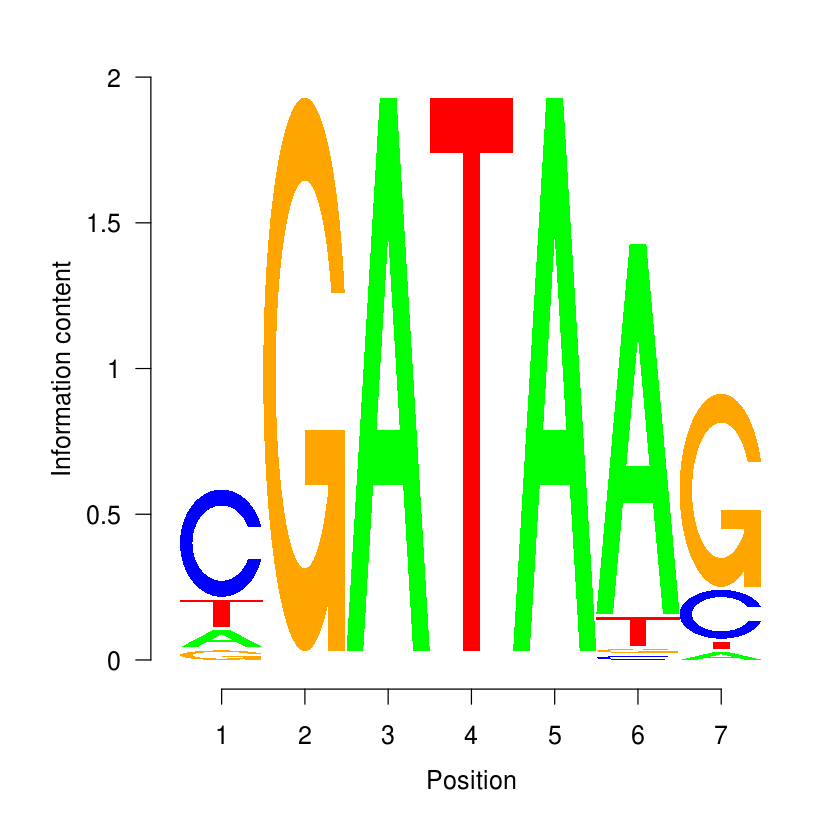

In [3]:
library(MotifDb)
library(seqLogo)
library(motifStack)
library(Biostrings)
library(GenomicFeatures)
library(org.Sc.sgd.db)
library(BSgenome.Scerevisiae.UCSC.sacCer3)
library(TxDb.Scerevisiae.UCSC.sacCer3.sgdGene)

query(MotifDb, "DAL80")   
pfm.dal80.jaspar <- query(MotifDb,"DAL80")[[1]]
seqLogo(pfm.dal80.jaspar)

In [4]:
dal1 <- "YIR027C"
chromosomal.loc <- 
  transcriptsBy(TxDb.Scerevisiae.UCSC.sacCer3.sgdGene, by="gene") [dal1]
promoter.dal1 <- 
  getPromoterSeq(chromosomal.loc, Scerevisiae, upstream=1000, downstream=0)
pcm.dal80.jaspar <- round(100 * pfm.dal80.jaspar)
matchPWM(pcm.dal80.jaspar, unlist(promoter.dal1)[[1]], "90%")

  Views on a 1000-letter DNAString subject
subject: TTGAGGAGTTGTCCACATACACATTAGTGTTGAT...GCAAAAAAAAAGTGAAATACTGCGAAGAACAAAG
views:
    start end width
[1]   620 626     7 [TGATAAG]
[2]   637 643     7 [CGATAAG]

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="sample-workflow">
Sample Workflow: an extended example
</h2>
We begin by visualizing DAL80's TF binding motif using either of two Bioconductor packages: seqLogo, and motifStack. First, query MotifDb for the PFM (position frequency matrix):

In [5]:
query(MotifDb,"DAL80")

MotifDb object of length 3
| Created from downloaded public sources: 2013-Aug-30
| 3 position frequency matrices from 3 sources:
|        JASPAR_2014:    1
|        JASPAR_CORE:    1
|             ScerTF:    1
| 1 organism/s
|        Scerevisiae:    3
Scerevisiae-JASPAR_CORE-DAL80-MA0289.1 
Scerevisiae-JASPAR_2014-DAL80-MA0289.1 
Scerevisiae-ScerTF-DAL80-harbison 

There are two motifs. How do they compare? The seqlogo package has been the standard tool for viewing sequence logos, but can only portray one logo at a time.

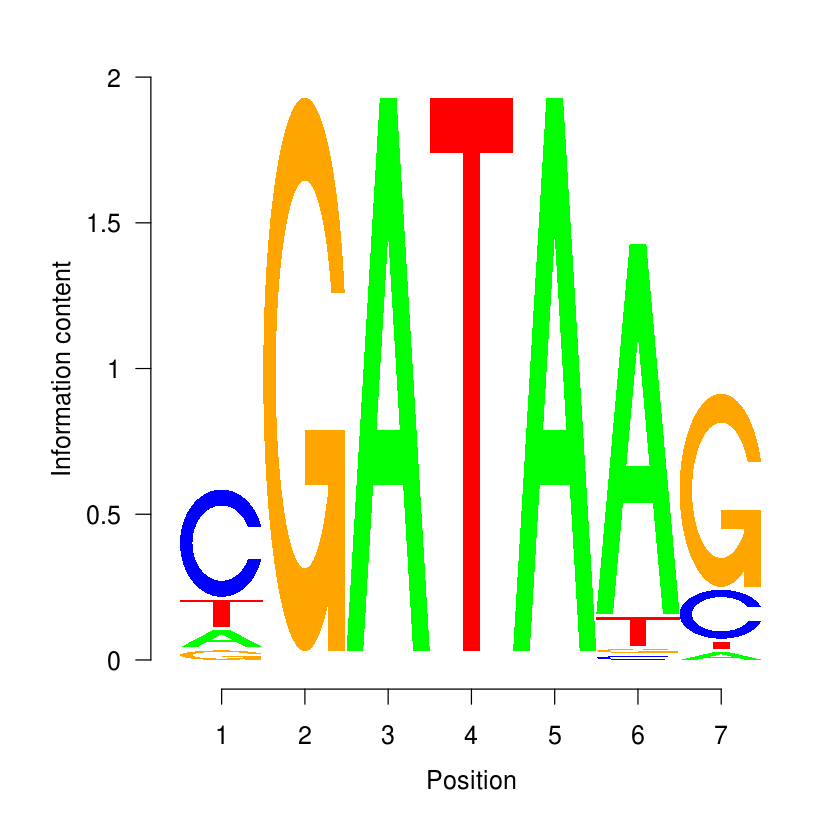

In [6]:
dal80.jaspar <- query(MotifDb,"DAL80")[[1]]
dal80.scertf <-query(MotifDb,"DAL80")[[2]]
seqLogo(dal80.jaspar)

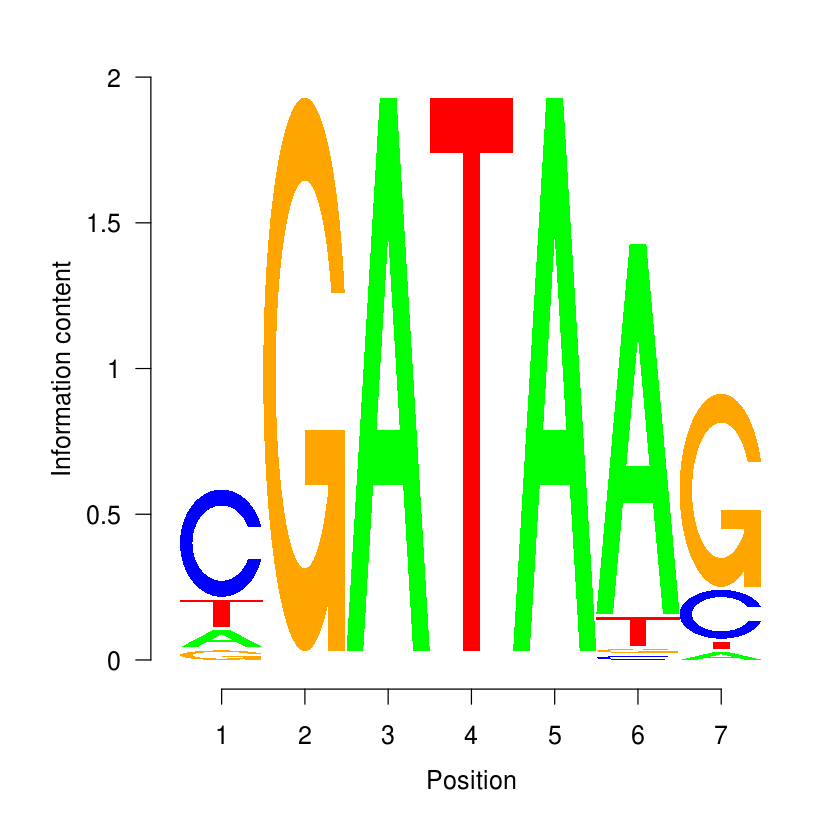

In [7]:
seqLogo(dal80.scertf)

With a little preparation, the new (October 2012) package motifStack can plot both motifs together. First, create instances of the <code>pfm</code> class:

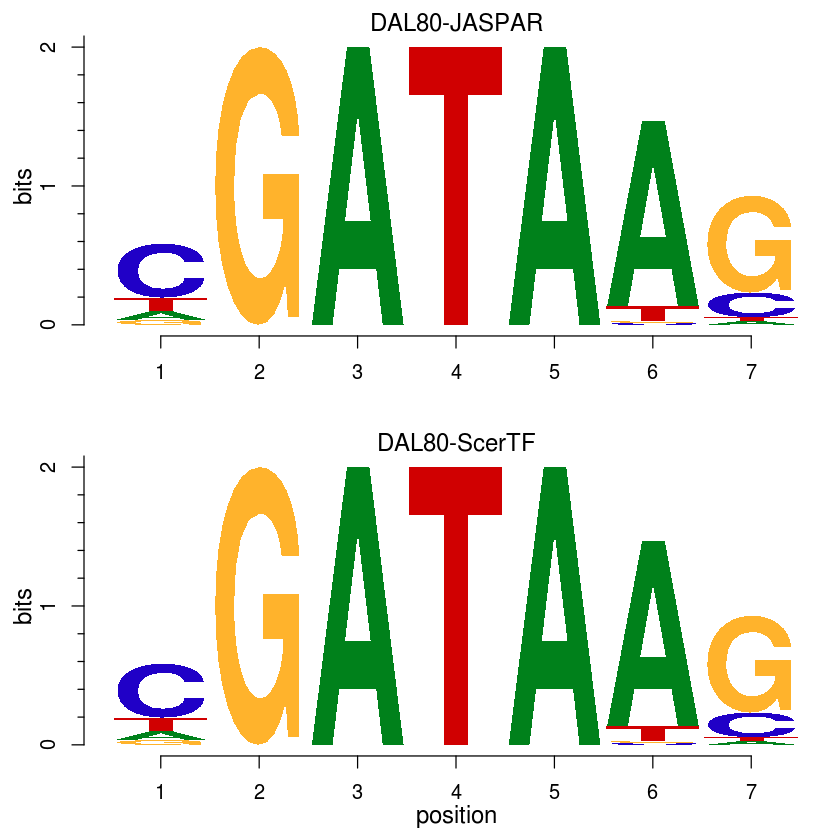

In [8]:
pfm.dal80.jaspar <- new("pfm", mat=query(MotifDb, "dal80")[[1]], 
                        name="DAL80-JASPAR")
pfm.dal80.scertf <- new("pfm", mat=query(MotifDb, "dal80")[[2]], 
                        name="DAL80-ScerTF")
plotMotifLogoStack(DNAmotifAlignment(c(pfm.dal80.scertf, pfm.dal80.jaspar)))

Of these two, the JASPAR motif has more detail, but the ScerTF motif is more recently published. ScerTF has a reputation for careful yeast-specific curation. We will use the ScerTF version.

Georis et al mention that DAL80 "competes with Gat1 for binding" -- suggesting that they would have highly similar motifs. MotifDb has 3 entries for GAT1:

In [9]:
query(MotifDb, "gat1")

MotifDb object of length 4
| Created from downloaded public sources: 2013-Aug-30
| 4 position frequency matrices from 4 sources:
|        JASPAR_2014:    1
|        JASPAR_CORE:    1
|             ScerTF:    1
|           UniPROBE:    1
| 1 organism/s
|        Scerevisiae:    4
Scerevisiae-JASPAR_CORE-GAT1-MA0300.1 
Scerevisiae-JASPAR_2014-GAT1-MA0300.1 
Scerevisiae-ScerTF-GAT1-zhu 
Scerevisiae-UniPROBE-Gat1.UP00287 

Plot the three together:

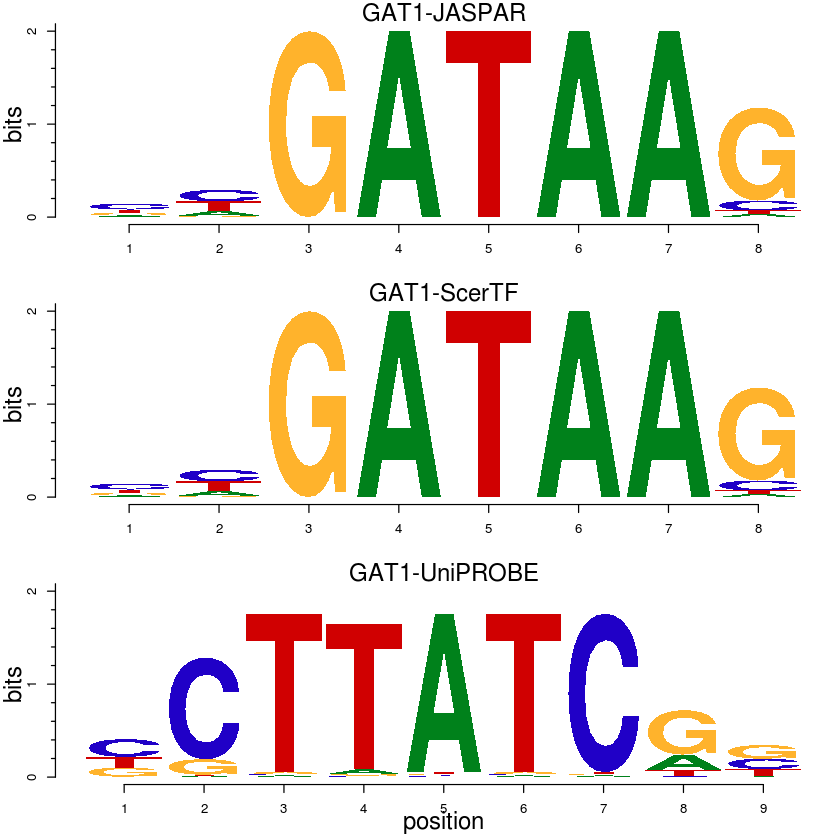

In [10]:
pfm.gat1.jaspar = new("pfm", mat=query(MotifDb, "gat1")[[1]], 
                       name="GAT1-JASPAR")
pfm.gat1.scertf = new("pfm", mat=query(MotifDb, "gat1")[[2]], 
                       name="GAT1-ScerTF")
pfm.gat1.uniprobe = new("pfm", mat=query(MotifDb, "gat1")[[3]], 
                       name="GAT1-UniPROBE")
plotMotifLogoStack(c(pfm.gat1.uniprobe, pfm.gat1.scertf, pfm.gat1.jaspar))

The GAT1-JASPAR motif is very similar to DAL80's GATAA motif, and thus consistent with the Georis claim that GAT1 and DAL80 compete for binding. The GAT1-ScerTF and GAT1-UniPROBE motifs are similar, but differ in length. They are reverse complements of the canonical <b>GATAA</b> motif.

To match motifs in a promoter, these steps are required:

-   Retrieve the binding motif (the position frequency matrix, or PFM) of a given transcription factor
-   Retrieve the promoter regions for a set of candidate targets
-   Identify the sequence matches of the binding motif in the the genes' promoter regions

The three search motifs, one for DAL80, and two for GAT1, must be transformed before then can be matched to DNA sequence. MotifDb returns a position frequency matrix (a <b>PFM</b>) with all columns summing to 1.0, but the Biostrings matchPWM method expects a position count matrix (a <b>PCM</b>) with integer values. Transform the frequency matrix into a count matrix using the somewhat arbitrary but functionally reliable scaling factor of 100:

In [11]:
pfm.dal80.scertf <- query(MotifDb, "dal80")[[2]]
pcm.dal80.scertf <- round(100 * pfm.dal80.scertf)

pfm.gat1.jaspar <- query(MotifDb, "gat1")[[1]]
pcm.gat1.jaspar <- round(100 * pfm.gat1.jaspar)

pfm.gat1.scertf <- query(MotifDb, "gat1")[[2]]
pcm.gat1.scertf <- round(100 * pfm.gat1.scertf)

Create a list of the seven genes from the DAL80 co-regulated subnetwork (displayed <a href=#network>above</a>). Lookup their systematic names, which will be needed immediately below.

In [12]:
genes <- c("DAL1", "DAL2", "DAL4", "DAL5", "DAL7", "DAL80", "GAP1")
orfs <- as.character(mget(genes, org.Sc.sgdCOMMON2ORF))

Obtain the coordinates of the transcripts for the orfs.

In [13]:
    grl <- transcriptsBy(TxDb.Scerevisiae.UCSC.sacCer3.sgdGene, by="gene") [orfs]

These coordinates, returned in a GRangesList object, specify the start location (chromosome and base pair) of every known transcript for each gene. With this information, GenomicFeatures::getPromoterSeq calculates and returns the DNA sequence of the promoter:

In [14]:
promoter.seqs <- getPromoterSeq(grl, Scerevisiae, upstream=1000,
                                downstream=0)

We will next search for a match of the motif to the first of these sequences, the promoter for DAL1. Note that here, and below, we use a 90% "min.score" when we call matchPWM. This high minimum match score seems reasonable given the relative absence of variability in DAL80's PFM:

In [15]:
pfm.dal80.scertf

,1,2,3,4,5,6,7
A,0.1089109,0.0000000,1.0000000,0.0000000,1.0000000,0.9090909,0.0300000
C,0.66336634,0.00000000,0.00000000,0.00000000,0.00000000,0.01010101,0.19000000
G,0.05940594,1.00000000,0.00000000,0.00000000,0.00000000,0.01010101,0.75000000
T,0.16831683,0.00000000,0.00000000,1.00000000,0.00000000,0.07070707,0.03000000


The <b>GATAA</b> pattern is a very strong signal in this motif.

Note that some restructuring is needed for us to use the results of <b>getPromoterSeqs</b> as an argument to <b>matchPWM</b>. We call the <b>getPromoterSeq</b> method with a GRangesList, which contains a unique set of genomic ranges, representing transcript coordinates, for each of several genes. The corresponding result is a <b>DNAStringSetList</b> in which there is one DNAStringSet (essentially a list of DNAStrings) for each gene in the input list. Both of these variables are therefore lists of lists, in which the outer list is named with genes, and the inner lists are per-transcript coordinates or DNA strings.

Since we need DNA strings without that overarching by-gene-name structure, we call <b>unlist</b> to strip off that structure, leaving us with the desired DNAStringSet:

In [16]:
print (class(promoter.seqs))
promoter.seqs <- unlist(promoter.seqs)
print (class(promoter.seqs))

matchPWM(pcm.dal80.scertf, promoter.seqs[[1]], "90%")

[1] "DNAStringSetList"
attr(,"package")
[1] "Biostrings"
[1] "DNAStringSet"
attr(,"package")
[1] "Biostrings"


  Views on a 1000-letter DNAString subject
subject: TTGAGGAGTTGTCCACATACACATTAGTGTTGAT...GCAAAAAAAAAGTGAAATACTGCGAAGAACAAAG
views:
    start end width
[1]   620 626     7 [TGATAAG]
[2]   637 643     7 [CGATAAG]

The close proximity of these two GATAA hits suggests that dimeric DAL80, or some other GATAA-binding dimer, may bind DAL1.

All of the matches in the promoters of all seven genes to one binding motif may be found at once with this command:

In [17]:
pwm.hits <- sapply(promoter.seqs, 
                      function(pseq) 
                         matchPWM(pcm.dal80.scertf, pseq, min.score="90%"))

And we can summarize the motif hits for each of the three motifs (dal80.scertf, gat1.jaspar, gat1.scertf) by creating a data.frame of counts, by gene and motif. First, determine the hits:

In [18]:
dal80.scertf.hits <- sapply(promoter.seqs, function(pseq) 
                            matchPWM(pcm.dal80.scertf, pseq, min.score="90%"))
gat1.scertf.hits  <- sapply(promoter.seqs, function(pseq) 
                            matchPWM(pcm.gat1.scertf, pseq, min.score="90%"))
gat1.jaspar.hits  <- sapply(promoter.seqs, function(pseq) 
                            matchPWM(pcm.gat1.jaspar, pseq, min.score="90%"))

Now count their lengths:

In [19]:
dal80.scertf <- sapply(dal80.scertf.hits, length)
gat1.jaspar  <- sapply(gat1.jaspar.hits,  length)
gat1.scertf  <- sapply(gat1.scertf.hits,  length)

Finally, create a data.frame from this information:

In [20]:
tbl.gata     <- data.frame(gene=genes, dal80.scertf, gat1.jaspar, gat1.scertf)

The simple <b>dal80.scertf</b> 5-base motif has the most hits. The more complex 8-base <b>gat1.jaspar</b> mtoif has fewer hits: perhaps it is over-specified. The 'other'(non-GATAA) motif of GAT1 obtained from ScerTF has fewer matches in the promoters of these genes than do the GATA motifs. The non-GATAA motif hits may in fact, be not much different from chance, as could be revealed by sampling the distribution of motif hits in the promoters of randomly selected genes. Such analyses will be left as an exercise for the reader.

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="biological-summary">
Biological Summary
</h2>
This dataset and our exploration has revealed a number of GATAA binding sites within these tighly co-regulated NCR genes, but leaves unanswered questions, some of which are:

-   GAT1 is reported to have two (or more) quite different binding motifs. Is this due to its having two or more distinct binding domains? Are they each functional, but only in different conditions?

-   The gene expression of the negative regulator DAL80 is highly correlated with the expression of genes it is known to repress. We would expect the opposite relationship between a negative regulator and its targets. Why doesn't abundant DAL80 prevent the expression of the other six genes?

-   The DAL80/ScerTF motif and GAT1/JASPAR motif are very closely related. The match table, just above, shows quite different totals for the two motifs. Does the find structure of the motif explain the difference?

One speculative explanation for the counter-intuitive DAL80 expression is "nuclear sequestration", a mechanism by which a gene is expressed but the mRNA is held in reserve for later use. See <a
href="http://www.ncbi.nlm.nih.gov/pubmed?term=22383896">Lavut A, Raveh D</a> 2012.

That GAT1 has multiple binding motifs (we show two, SGD <a href="http://www.yeastgenome.org/cgi-bin/locus.fpl?dbid=S000001873">four</a> is yet another indication of the incompletely understood complexity of gene regulation.

The four GATAA-binding regulators, two positive and two negative, and their many downstream targets, some of whose binding sequences we have studied here, can thus be seen to be parts of complex regulatory circuits whose full elucidation has not yet been worked out. Judicious integration of many other kinds of data, careful laboratory work, and the right computational tools, will eventually clarify them.

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>
<h2 id="exploring-package-content">
Exploring Package Content
</h2>
The packages used here have extensive help pages, and include vignettes highlighting common use cases. The help pages and vignettes are available from within an R session. After loading a package, type, for instance:

In [21]:
help(package="MotifDb")
?query

query {MotifDb},R Documentation
object,a MotifList object.
queryString,a character string
ignore.case,"a logical value, default TRUE"


Though it is quite simple, with only a few methods, it will be worthwhile understand the MotifDb package in detail. To access the vignette:

In [22]:
browseVignettes(package="MotifDb")

starting httpd help server ... done


Finally, you can open a web page containing comprehensive help resources for all installed packages:

In [23]:
help.start()

If the browser launched by '/usr/bin/firefox' is already running, it is
    *not* restarted, and you must switch to its window.
Otherwise, be patient ...


<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>

In [24]:
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] TxDb.Scerevisiae.UCSC.sacCer3.sgdGene_3.2.2
 [2] BSgenome.Scerevisiae.UCSC.sacCer3_1.4.0    
 [3] BSgenome_1.38.0                            
 [4] rtracklayer_1.30.1                         
 [5] org.Sc.sgd.db_3.2.3                        
 [6] RSQLite_1.0.0                              
 [7] DBI_0.3.1                                  
 [8] GenomicFeatures_1.22.6    

<p class="back_to_top">
\[ <a href="#top">Back to top</a> \]
</p>